# *lenstronomy* starting guide

Welcome to lenstronomy!

This notebook aims to describe the basic functionalities of the most important modules of *lenstronomy* with some simple examples. More detailed information about the available routines and their use can be accessed through the [online documentation](https://readthedocs.com/lenstronomy) and in many other [Jupyter notebooks](https://github.com/sibirrer/lenstronomy_extensions).

Also, we refer to the [strong lensing lecture notes](https://github.com/sibirrer/strong_lensing_lectures) in Jupyter form for a brief introduction in strong gravitational lensing.


<div class="alert alert-warning">

**Disclamer:** Please reach out to the developers if you have questions! This is true for a beginner in gravitational lensing or have substantial experience with other lensing codes. Your questions and feedback is very valuable for us to improve the software and its documentation.

</div>


In [1]:
# some standard python imports #
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

## $\texttt{LensModel}$ module
$\texttt{LensModel}$ and its sub-packages execute all the purely lensing related tasks of *lenstronomy*. This includes ray-shooting, solving the lens equation, arrival time computation and non-linear solvers to optimize lens models for specific image configurations. The module allows consistent integration with single and multi plane lensing and an arbitrary superpositions of lens models. There is a wide range of lens models available. For details we refer to to the online-documentation.

### Single plane lensing
As an example of initializing a single plane lens model as a super-position of an elliptical power-law potential and a singular isothermal sphere mass distribution and execute some basic routines:

In [2]:
# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['EPL', 'SHEAR']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_spep = {'theta_E': 1.1, 'e1': 0.1, 'e2': 0.1, 'gamma': 2., 'center_x': 0.1, 'center_y': 0}
kwargs_shear = {'gamma1': -0.01, 'gamma2': .03}
kwargs_lens = [kwargs_spep, kwargs_shear]


# image plane coordinate #
theta_ra, theta_dec = 1., .5

# source plane coordinate #
beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)
# Fermat potential #
fermat_pot = lensModel.fermat_potential(x_image=theta_ra, y_image=theta_dec, x_source=beta_ra, y_source=beta_dec, kwargs_lens=kwargs_lens)

# Magnification #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

Additionally, the $\texttt{LensModel}$ class allows to compute the Hessian matrix, shear and convergence, deflection angle and lensing potential. These routines are fully compatible with the numpy array structure and as a superposition of an arbitrary number of single lens models.

### Multi-plane lensing

The multi-plane setting of $\texttt{LensModel}$ allows to place the different deflector models at different redshifts. When not further specified, the default cosmology of the $\texttt{astropy}$ cosmology class. The interface to access the lensing functionalities remains the same.
In this example we add an additional Singular Isothermal Sphere (SIS) model at a different redshfit.

In [3]:
# keep the imports and variables from above #
# specify redshifts of deflectors #
redshift_list = [0.5, 0.5, 0.8]
# specify source redshift #
z_source = 1.5
# setup lens model class with the list of lens models #
lens_model_list_mp = ['EPL', 'SHEAR', 'SIS']
lensModel_mp = LensModel(lens_model_list=lens_model_list_mp, z_source=z_source, lens_redshift_list=redshift_list, multi_plane=True)

kwargs_sis = {'theta_E': 0.1, 'center_x': 1., 'center_y': -0.1}
kwargs_lens_mp = [kwargs_spep, kwargs_shear, kwargs_sis]

# source plane coordinate #
beta_ra, beta_dec = lensModel_mp.ray_shooting(theta_ra, theta_dec, kwargs_lens_mp)

# Magnification #
mag = lensModel_mp.magnification(theta_ra, theta_dec, kwargs_lens_mp)

# arrival time relative to a straight path through (0,0) #
dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens_mp)

### Q: change the redshift of the other lens, how does this affect the images?

### lens equation solver

Solving the lens equation to compute the (multiple) image positions of a given source position can be conveniently performed within $\texttt{LensModel}$ and is supported with a general instance of the $\texttt{LensModel}$ class.

In [4]:
# keep the imports and variables from above #
# import the lens equation solver class #
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

# the magnification of the point source images #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

### illustration of lens models
The lens models can be conveniently illustrated with routines present in the $\texttt{Plot}$ module. As an option, you can plot the critical curves and caustics, which are computationally the most demanding part.

/var/folders/2r/gwrt1nq934zd6xky7hbfb8_80000gn/T/ipykernel_72568/3807885781.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


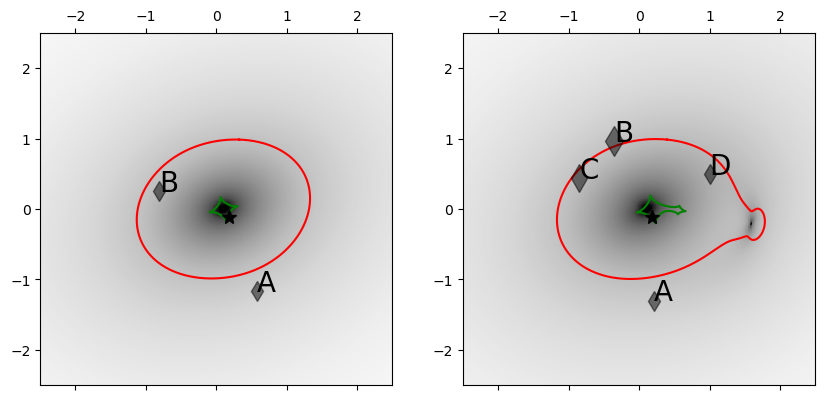

In [5]:
from lenstronomy.Plots import lens_plot
f, axex = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex[0], lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
lens_plot.lens_model_plot(axex[1], lensModel=lensModel_mp, kwargs_lens=kwargs_lens_mp, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
f.show()

### Q: add titles to the two plots above. 

## $\texttt{LightModel}$ module

The $\texttt{LightModel}$ class provides the functionality to describe galaxy surface brightnesses. $\texttt{LightModel}$ supports various analytic profiles as well as representations in shapelet basis sets. Any superposition of different profiles is allowed.

The parameter levelig the amplitude of the surface brightness of a certain profile is named 'amp'. The units are not further specified and are effectively reflecting a surface brightness quantitiy integrated over the unit of angle square. In the $\texttt{SimulationAPI}$ module, the user can conveniently chose astronomical magnitudes as inputs to the profiles, provided the magnitude zero point is declared. Have a look at the specific notebook to see a demonstration.

In [6]:
# import the LightModel class #
from lenstronomy.LightModel.light_model import LightModel
# set up the list of light models to be used #
source_light_model_list = ['SERSIC']
lightModel_source = LightModel(light_model_list=source_light_model_list)
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)
# define the parameters #
kwargs_light_source = [{'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]
import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_light_lens = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]

# evaluate surface brightness at a specific position #
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

## $\texttt{PointSource}$ module
To accurately predict and model the positon and flux of point sources, one has to apply different numerical procedures than for extended surface brightness features. The $\texttt{PointSource}$ class manages the different options in describing point sources (e.g. in the image plane or source plane, with fixed magnification or allowed with individual variations thereof) and provides a homogeneous interface to access image positions and magnifications.

In [7]:
# import the PointSource class #
from lenstronomy.PointSource.point_source import PointSource

# unlensed source positon #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lens_model=lensModel, fixed_magnification_list=[True])
kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 100}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

# lensed image positions (solution of the lens equation) #
point_source_model_list = ['LENSED_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lens_model=lensModel, fixed_magnification_list=[False])
kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': np.abs(mag)*30}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

### Q: compare the lensed and the unlesed source positions.

### Q: how many images are being generated?

## $\texttt{Data}$ module
The $\texttt{PixelGrid}$ class stores and manages the coordinate frame and. the coordinate-to-pixel transformation necessary to simulate images.
The $\texttt{PSF}$ class handles the point spread function convolution. Supported are pixelized convolution kernels as well as some analytic profiles.

The $\texttt{Data}$ class inherits the $\texttt{PixelGrid}$ and in addition manages data specific quantities (pixel values and noise properties) that are required when fitting models to data to estimate the likelihood of the data given a model. To simulate a mock lens, we only require an instance of the $\texttt{PixelGrid}$ and $\texttt{PSF}$ class.

In [8]:
# import the PixelGrid() class #
from lenstronomy.Data.pixel_grid import PixelGrid
deltaPix = 0.05  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.1,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

## $\texttt{ImSim}$ module
The $\texttt{ImSim}$ module simulates images. At its core is the $\texttt{ImageModel}$ class. It is the interface to combine all the different components, $\texttt{LensModel}$, $\texttt{LightModel}$, $\texttt{PointSource}$ and $\texttt{Data}$ to model images. The $\texttt{LightModel}$ can be used to model lens light (unlensed) or source light (lensed). $\texttt{ImSim}$ is fully supporting all functionalities in each component. Additionaly, numerical precision arguments can be set in how to model the image.

### Simulate image
We simulate an image with an instance of $\texttt{ImageModel}$ that got instances of the classes we created above. We can define two different $\texttt{LightModel}$ instances for the lens and source light. Additionally, we can define the sub-pixel ray-tracing resolution and whether the PSF convolution is applied on the higher resolution ray-tracing image or on the degraded pixel image.

In this example, we do not simulate point source. You can look at the notebooks dedicated to model quads and doubles and also for time-delya cosmography.

/var/folders/2r/gwrt1nq934zd6xky7hbfb8_80000gn/T/ipykernel_72568/2212537119.py:26: RuntimeWarning: invalid value encountered in log10
  axes[1].matshow(np.log10(image_noisy), origin='lower')


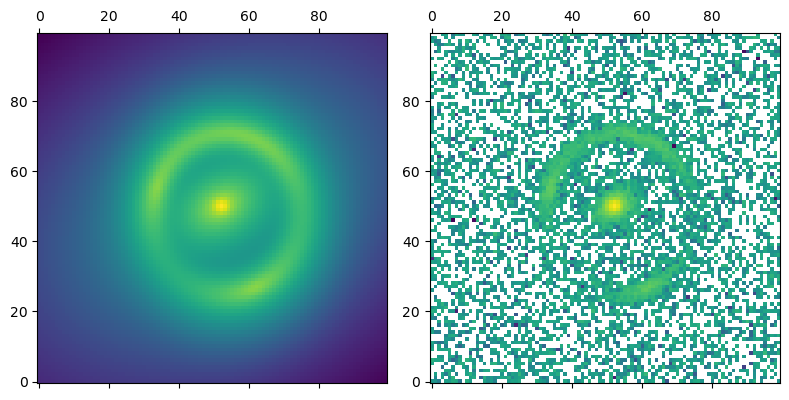

In [9]:
# import the ImageModel class #
from lenstronomy.ImSim.image_model import ImageModel
# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

# we can also add noise #
import lenstronomy.Util.image_util as image_util
exp_time = 100  # exposure time to quantify the Poisson noise level
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
axes[0].matshow(np.log10(image), origin='lower')
axes[1].matshow(np.log10(image_noisy), origin='lower')
f.tight_layout()
plt.show()